# Stage 0: Input Validation (Skin vs. Background) 🛡️

This notebook verifies the "Stage 0" filter, which is responsible for rejecting non-human/irrelevant images (e.g., furniture, cars, animals) before they reach the medical models.

**Model:** MobileNetV3-Small (trained on Wound Dataset vs. CIFAR-10)
**Goal:** Ensure 100% rejection of irrelevant images.

In [1]:
import torch
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
from pathlib import Path
import os
import glob
import numpy as np

# Config
MODEL_PATH = "../models/stage0_filter/stage0_mobilenet_v3.pth"
MODEL_NAME = "mobilenetv3_small_100"
IMG_SIZE = 224
THRESHOLD = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using Device: cuda


## 1. Load Model
We load the lightweight MobileNetV3 model trained in `src/stage0_filter_train.py`.

In [2]:
def load_model(weights_path):
    if not os.path.exists(weights_path):
        print("❌ Weights not found! Please run src/stage0_filter_train.py first.")
        return None
    
    model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=1)
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    print("✅ Model Loaded Successfully")
    return model

model = load_model(MODEL_PATH)

✅ Model Loaded Successfully


## 2. Prediction Function

In [3]:
# Preprocessing matches training
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict_and_plot(image_path):
    try:
        # Load and Preprocess
        original_img = Image.open(image_path).convert("RGB")
        input_tensor = preprocess(original_img).unsqueeze(0).to(device)

        # Inference
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
            
        # Visualize
        plt.figure(figsize=(4, 4))
        plt.imshow(original_img)
        plt.axis('off')
        
        label = "✅ RELEVANT (SKIN)" if prob > THRESHOLD else "⛔ IRRELEVANT (JUNK)"
        color = "green" if prob > THRESHOLD else "red"
        
        plt.title(f"{label}\nScore: {prob:.2%}", color=color, fontweight='bold')
        plt.show()
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

## 3. Test on "Background/Negative" Samples
These are images from CIFAR-10 (Upscaled) that should be REJECTED.

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9940 (\N{NO ENTRY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


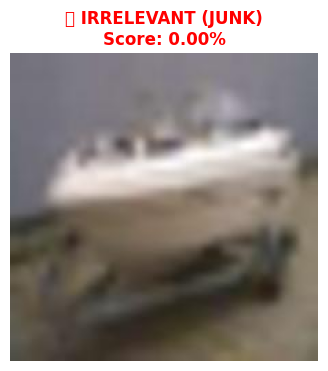

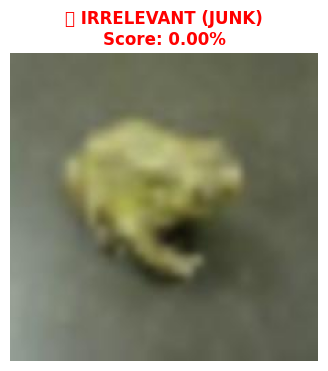

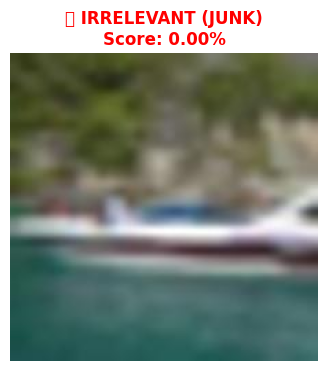

In [4]:
bg_dir = Path("../data/raw/background_class")
if bg_dir.exists():
    test_files = list(bg_dir.glob("*.jpg"))
    # Pick 3 random files
    if len(test_files) > 0:
        for f in np.random.choice(test_files, 3, replace=False):
            predict_and_plot(f)
    else:
        print("No files found in background directory.")
else:
    print("Background directory not found.")

## 4. Test on "Positive" Samples
These are wound images that should be ACCEPTED.

f:\Housepital-AI\Housepital-AI\venv_gpu\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


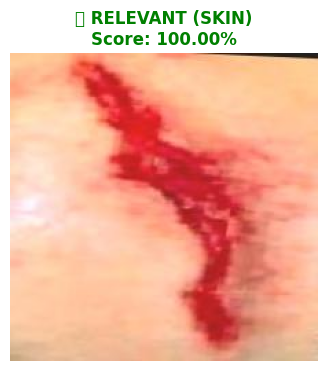

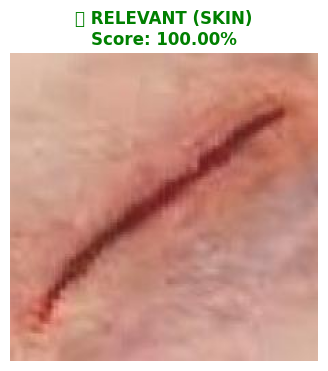

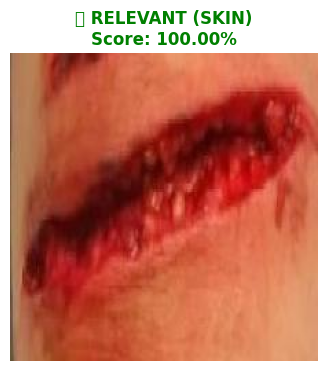

In [5]:
pos_dir = Path("../data/raw/type_classification/cut") # Example class
if pos_dir.exists():
    test_files = list(pos_dir.glob("*.jpg"))
    if len(test_files) > 0:
         for f in np.random.choice(test_files, 3, replace=False):
            predict_and_plot(f)
    else:
        print("No files found in wound directory.")
else:
    print("Wound directory not found.")

## 5. Custom Test
Change the path below to test any external image.

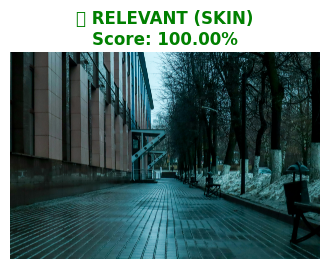

In [ ]:
# Example Usage:
# predict_and_plot("C:/Users/Aly/Downloads/test_image.jpg")
# predict_and_plot("E:\\download\\58401.jpg")
# predict_and_plot("E:\\download\\Camera-RAW_Edit-side-by-side_Owned_1200.jpg")
# predict_and_plot("E:\\download\\cd931db5-b8d8-46a9-b3f0-762cb5a7daf0.jpeg")
# predict_and_plot("E:\\download\\Gemini_Generated_Image (1).jpg")
# predict_and_plot("E:\\download\\images (1).jpeg")
# predict_and_plot("E:\\download\\marwan-5mCmxWECnBI-unsplash.jpg")